# Imports

In [1]:
#imports
import torch
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import random
from torchvision import transforms
import cv2
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image
import time
from torch.utils.data import Dataset, DataLoader, random_split

# HELPER FUNCTIONS

In [8]:
# All helper functions for dataloader
def load_images(path):
    images = []
    valid_images = [".jpeg", ".jpg", '.png']
    for img in os.listdir(path):
        ext = os.path.splitext(img)[1]
        if ext.lower() not in valid_images:
            continue
        else:
            images.append(os.path.join(path, img))
    return images

def denormalize_tensor(normalize_tensor):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    return inv_normalize(normalize_tensor)

def plot_tensor(input_tensor, label):
    input_tensor = input_tensor.detach().cpu().numpy()
    input_tensor =  np.transpose(input_tensor, (1,2,0))
    plt.figure()
    plt.imshow(input_tensor, cmap='gray')
    plt.title(str(label))

    

# DATALOADERS

In [9]:
class DataloaderGenerator(Dataset):
    def __init__(self, dataset_path, shape=(128, 96)):
        super().__init__()
        self.dataset_path = dataset_path

        self.cloth_directory = 'cloth' # y_i
        self.cloth_paths = load_images(os.path.join(self.dataset_path, self.cloth_directory))

        self.cloth_mask_directory = 'cloth-mask' # it should be mask for output image/ target cloth mask
        self.cloth_mask_paths = load_images(os.path.join(self.dataset_path, self.cloth_mask_directory))

        self.person_image_directory = 'image' # x_i
        self.person_image_paths = load_images(os.path.join(self.dataset_path, self.person_image_directory))

        self.image_normalization = transforms.Normalize(
            [0.485, 0.456, 0.406],  # mean
            [0.229, 0.224, 0.225]  # std
        )

        self.mask_normalization = transforms.Normalize(
            [0.5], [0.5]
        )

        self.image_transform = transforms.Compose([
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.image_normalization
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.mask_normalization
        ])

    def __len__(self):
        return len(self.cloth_paths)

    def __getitem__(self, idx):
        cloth_path = self.cloth_paths[idx]
        person_image_path = self.person_image_paths[idx]
        #cloth_mask_path = self.cloth_mask_paths[idx] -- No lonnger using mask for input cloth -- we have to use mask for target cloth

        target_cloth_idx = random.randint(0, len(self.cloth_paths) - 1)
        target_cloth_path = self.cloth_paths[target_cloth_idx]
        cloth_mask_path = self.cloth_mask_paths[target_cloth_idx]

        cloth_img = Image.open(cloth_path)
        person_img = Image.open(person_image_path)
        person_mask_img = Image.open(cloth_mask_path)
        target_cloth_img = Image.open(target_cloth_path)

        cloth_img = self.image_transform(cloth_img)
        person_img = self.image_transform(person_img)
        target_cloth_img = self.image_transform(target_cloth_img)
        person_mask_img = self.mask_transform(person_mask_img)

        return cloth_img, person_img, person_mask_img, target_cloth_img

In [10]:
class DataloaderDiscriminator(object):
    def __init__(self, dataset_path, shape=(128, 96)):
        super().__init__()
        self.dataset_path = dataset_path
        self.cloth_directory = 'cloth'
        self.cloth_paths = load_images(os.path.join(self.dataset_path, self.cloth_directory))

        self.person_image_directory = 'image'
        self.person_image_paths = load_images(os.path.join(self.dataset_path, self.person_image_directory))

        self.normalization = transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
        self.image_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Resize(shape),
            transforms.CenterCrop(shape),
            transforms.ToTensor(),
            self.normalization
        ])

    def __len__(self):
        return len(self.cloth_paths)

    def __getitem__(self, idx):
        cloth_path = self.cloth_paths[idx]
        person_image_path = self.person_image_paths[idx]

        cloth_img = Image.open(cloth_path)
        person_img = Image.open(person_image_path)

        cloth_img = self.image_transform(cloth_img)
        person_img = self.image_transform(person_img)

        return cloth_img, person_img


# Testing DataLoaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


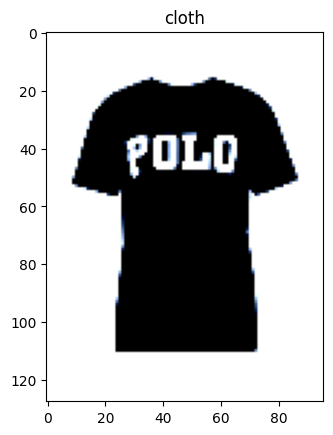

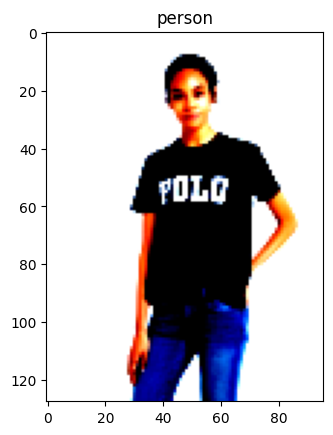

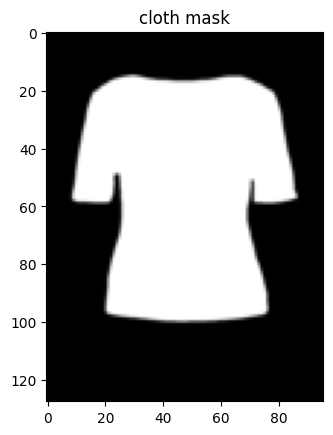

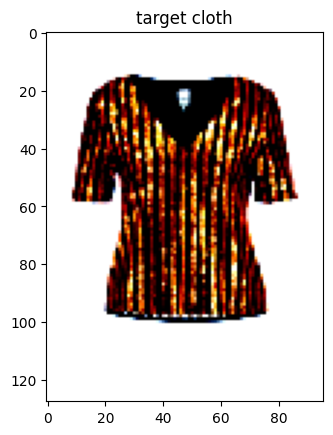

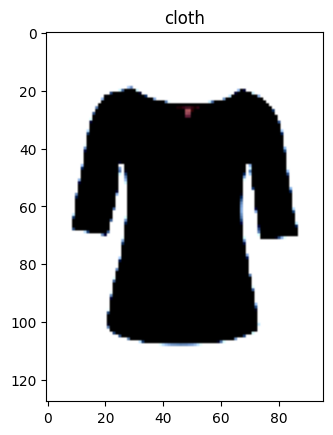

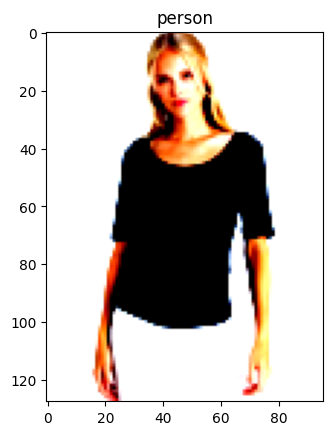

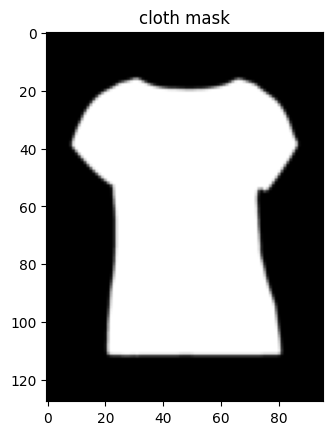

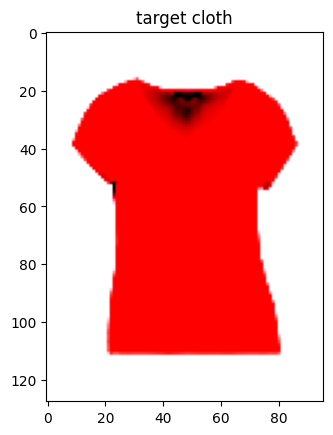

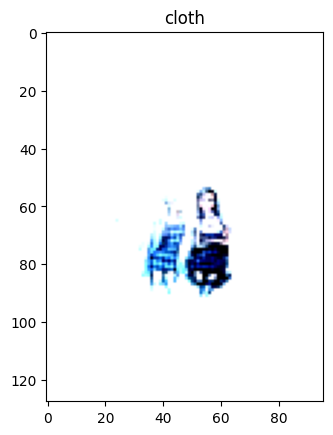

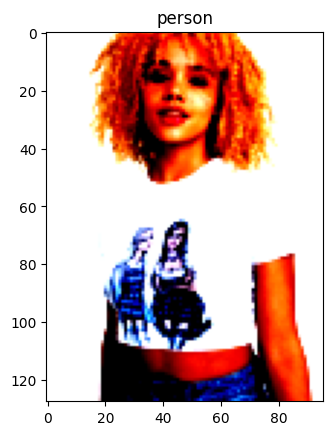

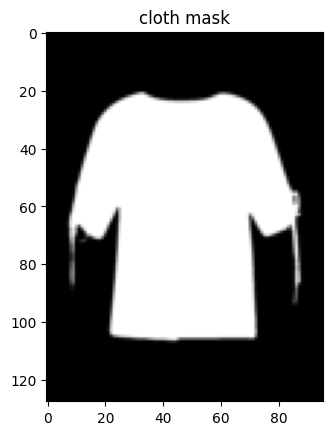

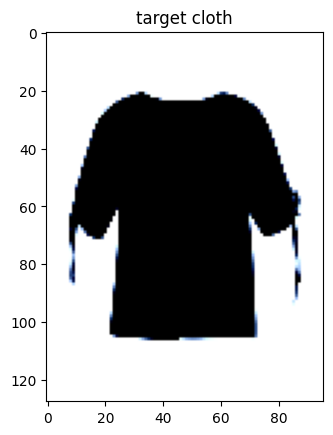

In [5]:

gen =  DataloaderGenerator('/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train')
for i in range(3):
    c, p, pm, tc = gen.__getitem__(i)
    plot_tensor(c,'cloth') # y_i
    plot_tensor(p,'person') # x_i
    plot_tensor(pm,'cloth mask') # ??
    plot_tensor(tc,'target cloth') # y_j --target


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


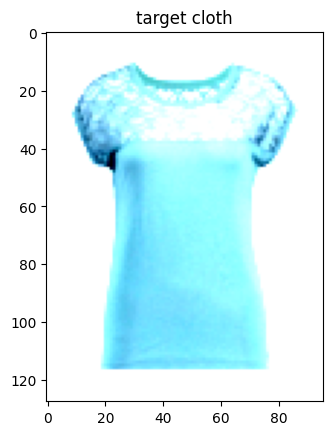

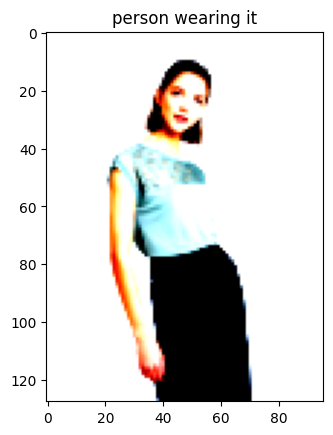

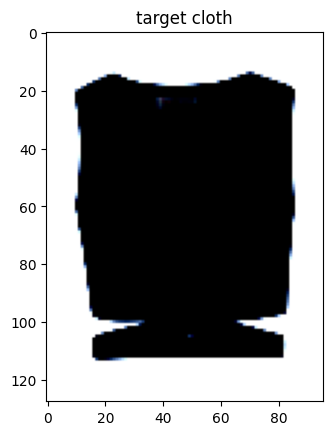

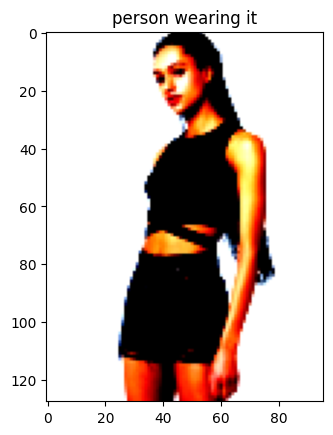

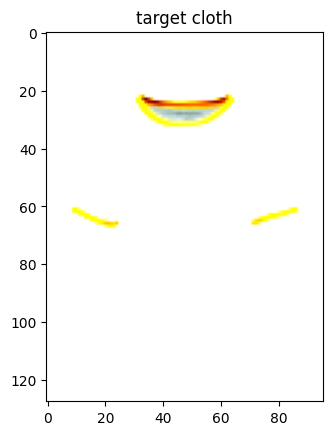

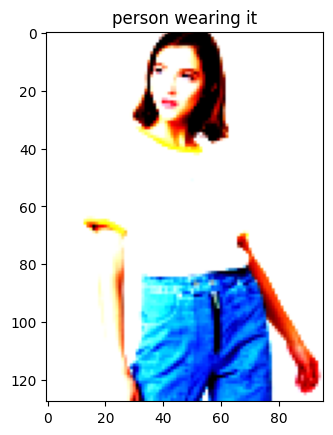

In [6]:
dis =  DataloaderDiscriminator('/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train')
for i in range(3):
    j = random.randint(0,11640)
    c, p = dis.__getitem__(j)
    plot_tensor(c,'target cloth')
    plot_tensor(p,'person wearing it')
  

# Model Architecture

In [5]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder side
        self.encoder = nn.Sequential(
            nn.Conv2d(9, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=512),
    
        )

        # Decoder side
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, ),
            nn.InstanceNorm2d(num_features=256),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=128),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=64),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x_2 = self.encoder[0:2](x)
        x_3 = self.encoder[2:5](x_2)
        x_4 = self.encoder[5:8](x_3)
        x_5 = self.encoder[8:](x_4)
        
        x = x_5
        
        x = self.decoder[0:3](x)
        x = torch.cat([x, x_4], 1)
        x = self.decoder[3:6](x)
        x = torch.cat([x, x_3], 1)
        x = self.decoder[6:9](x)
        x = torch.cat([x, x_2], 1)
        x = self.decoder[9:](x)

        return x


In [6]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1,padding_mode='reflect'), #6*128*96
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1,padding_mode='reflect'), #64*64*48
            nn.InstanceNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1,padding_mode='reflect'), #128*32*24
            nn.InstanceNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1,padding_mode='reflect'), #256*16*12
            nn.InstanceNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1), #512*8*6
             nn.InstanceNorm2d(num_features=1),
            #1*4*3
            nn.Conv2d(1,1, kernel_size=3, stride = 2, padding=1),
            nn.InstanceNorm2d(num_features=1), #1*2*2
        )

        # output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=4, stride=2, padding = 1, padding_mode='reflect'), 
            nn.Sigmoid(), #output = 1*7*5

        )

    

    def forward(self, x):
        x = self.features(x)
        x = self.output_layer(x)
        x = torch.squeeze(x, -1)
        x = torch.squeeze(x, -1)
        return x # real/fake --PatchGAN


In [51]:
def test():
    img_channel = 9
    img_w = 128
    img_h = 96
    x = torch.randn((2,img_channel,img_w,img_h))
    gen = Generator()
    res = gen.forward(x)
    print(res.shape)

if __name__ == "__main__":
    test()

torch.Size([2, 4, 128, 96])


In [85]:
def test():
    img_channel = 6
    img_w = 128
    img_h = 96
    x = torch.randn((2,img_channel,img_w,img_h))
    gen = Discriminator()
    res = gen.forward(x)
    print(res.shape)
    real = torch.ones_like(res)
    print(real.shape)

if __name__ == "__main__":
    test()

torch.Size([2, 1])
torch.Size([2, 1])


# Training Loop

### Parameters

In [ ]:
epochs_num = 100
batch_size = 16
lr = 0.002
device = torch.device("mps")

# Define losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss() 
criterion_identity = torch.nn.L1Loss() 

In [16]:
generator =  Generator()
discriminator =  Discriminator()


In [ ]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)
generator.train()
discriminator.train()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
scaler_G = torch.cuda.amp.GradScaler()
scaler_D = torch.cuda.amp.GradScaler()
dataset_path = '/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train'
dataloader_generator = torch.utils.data.DataLoader(DataloaderGenerator(dataset_path),
                                                    batch_size=batch_size, shuffle=True, drop_last=True)

torch.autograd.set_detect_anomaly(True)
best_generator_loss = float('inf')
best_discrimnator_loss = float('inf')

for epoch in range(epochs_num):
    start_epoch_time = time.time()
    dataloader_generator_lenght =  len(dataloader_generator)
    for i, (cloth, person_with_cloth, person_with_cloth_mask, target_cloth) in enumerate(dataloader_generator):

        real_cloth = cloth.to(device) #y_i
        real_person_with_cloth = person_with_cloth.to(device) #x_i
        real_target_cloth = target_cloth.to(device) # y_j
        person_with_cloth_mask = person_with_cloth_mask.to(device) # y_i_mask 

        # Adversarial ground truths
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(0.9), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.1), requires_grad=False).to(device)

        # -----------------
        #  Train Generators
        # -----------------

        optimizer_G.zero_grad() # clear gradients 

        with torch.cuda.amp.autocast(): # Mixed precision training
            
            input_to_generator1 = torch.cat((real_cloth, real_person_with_cloth, real_target_cloth), dim=1)
            output_from_generator1 = generator(input_to_generator1)
            generated_img1, mask1 = torch.split(output_from_generator1, [3, 1], dim=1) # alpha = mask 1 --- x_i_j = generated_img1 , mask1 is mask for swapped cloth
            
            
            
            #fake_output = mask1*generated_img1 + (1-mask1)*real_person_with_cloth # added this line --- alpha*x_i_j + (1-alpha)*x_i -- this is final output

            generated_img1 = mask1*generated_img1 + (1-mask1)*real_person_with_cloth
            # Alpha losss
            loss_identity_mask1 =  criterion_identity(mask1, person_with_cloth_mask)


            # Gan
            input_to_discriminator_gen_train1 = torch.cat((generated_img1, real_target_cloth), dim=1)
            output_form_discriminator_gen_train1 = discriminator(input_to_discriminator_gen_train1)
            # GAN loss
            loss_gan1 = criterion_GAN(output_form_discriminator_gen_train1, torch.ones_like(output_form_discriminator_gen_train1).to(device)) #made change
            
            input_to_generator2 = torch.cat((real_target_cloth, generated_img1, real_cloth), dim=1)
            output_from_generator2 = generator(input_to_generator2)
            generated_img2, mask2 = torch.split(output_from_generator2, [3, 1], dim=1)

            generated_img2 = mask2*generated_img2 + (1-mask2)*generated_img1 # calculated output of generator 2 as well in same way



            # identyty loss
            loss_identity_mask2 =  criterion_identity(mask2, person_with_cloth_mask)
            # Gan
            input_to_discriminator_gen_train2 = torch.cat((generated_img2, real_cloth), dim=1)
            output_form_discriminator_gen_train2 = discriminator(input_to_discriminator_gen_train2)
            # GAN loss
            loss_gan2 = criterion_GAN(output_form_discriminator_gen_train2, torch.ones_like(output_form_discriminator_gen_train2).to(device)) #made change
            # cycle
            loss_cycle_gen = criterion_cycle(generated_img2, real_person_with_cloth)
            # loses
            loss_identity_gen = (loss_identity_mask1 + loss_identity_mask2) / 2
            loss_gan = (loss_gan1+loss_gan2)/2
            g_loss = loss_gan + 0.1 * loss_identity_gen + loss_cycle_gen


        scaler_G.scale(g_loss).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        if i % 5 == 0:
            optimizer_D.zero_grad()

            generated_img1 = generated_img1.detach()
            generated_img2 = generated_img2.detach()

            with torch.cuda.amp.autocast():
                # Loss for real images 1
                cloth, person_with_cloth = real_cloth, real_person_with_cloth
                real_cloth = cloth.to(device)
                real_person_with_cloth = person_with_cloth.to(device)

                input_to_discriminator_dis_train_real = torch.cat((real_person_with_cloth, real_cloth), dim=1)
                output_form_discriminator_dis_train = discriminator(input_to_discriminator_dis_train_real)

                d_real_loss = criterion_GAN(output_form_discriminator_dis_train, torch.ones_like(output_form_discriminator_dis_train).to(device)) #made change
                
                # Loss for fake images 1
                input_to_discriminator_dis_train_fake1 = torch.cat((generated_img1, real_target_cloth), dim=1)

                output_form_discriminator_dis_train1 = discriminator(input_to_discriminator_dis_train_fake1)

                d_fake_loss1 = criterion_GAN(output_form_discriminator_dis_train1, torch.zeros_like(output_form_discriminator_dis_train1).to(device))
                # Loss for fake images 2
                input_to_discriminator_dis_train_fake2 = torch.cat((generated_img2, real_target_cloth), dim=1)

                output_form_discriminator_dis_train2 = discriminator(input_to_discriminator_dis_train_fake2)

                d_fake_loss = criterion_GAN(output_form_discriminator_dis_train2, torch.zeros_like(output_form_discriminator_dis_train2).to(device))
                d_loss = (d_real_loss + d_fake_loss) / 2

            scaler_D.scale(d_loss).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()


    print(
        "[Epoch ", epoch,"] [D loss: ,",d_loss.item(),",] [G loss: ",g_loss.item(),"]"
    )

        
    generator_model_name = "generator_epoch_"+str(epoch)
    generator_model_path = os.path.join("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Code/WearVision/Fitting Model/Model/Generator/", generator_model_name)

    discriminator_model_name = "discriminator_epoch"+str(epoch)
    discriminator_model_path = os.path.join("/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Code/WearVision/Fitting Model/Model/Discriminator/", discriminator_model_name)

        # save generated image & mask after each epoch
    save_image([tensor for idx, tensor in enumerate(generated_img1.data) if idx <16], f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/code/WearVision/Fitting Model/images/images_{epoch}.png', nrow=4)
    save_image([tensor for idx, tensor in enumerate(mask1.data) if idx <16], f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/code/WearVision/Fitting Model/masks/masks_{epoch}.png', nrow=4)
    if g_loss.item() < best_generator_loss:
        torch.save(generator, generator_model_path)
        best_generator_loss = g_loss.item()
    if d_loss.item() < best_discrimnator_loss:
        torch.save(discriminator, discriminator_model_path)
        best_discrimnator_loss = d_loss.item()
    time_per_epoch = time.time() - start_epoch_time
    print("time per epoch: ",time_per_epoch)

### Testing results

In [44]:
import __main__
#setattr(__main__, "Generator", Generator)
model = torch.load('/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Code/WearVision/Fitting Model/Model/Generator/generator_epoch_13')
model =  model.to('mps')
model.eval()

Generator(
  (encoder): Sequential(
    (0): Conv2d(9, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): ReLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Instan

In [45]:

shape = (128,96)
image_normalization = transforms.Normalize([0.485, 0.456, 0.406],  [0.229, 0.224, 0.225]  )

mask_normalization = transforms.Normalize([0.5], [0.5])

image_transform = transforms.Compose([
transforms.Resize(shape),
transforms.CenterCrop(shape),
transforms.ToTensor(),
image_normalization])

mask_transform = transforms.Compose([
transforms.Resize(shape),
transforms.CenterCrop(shape),
transforms.ToTensor(),
mask_normalization
])

In [46]:
def process_image(input_path):
    image = Image.open(input_path)
    image = image_transform(image)
    return image

def process_mask(input_path):
    mask = Image.open(input_path)
    mask = mask_transform(mask)
    return mask

def load_img(input_path):
    image = Image.open(input_path)
    return image

In [47]:
x_i = [process_image(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/image/0000{i}_00.jpg') for i in range(0,4)]
y_i = [process_image(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/cloth/0000{i}_00.jpg') for i in range(0,4)]
y_j  = [process_image(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/cloth/000{i}_00.jpg') for i in range(22,26)]
mask = [process_mask(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/cloth-mask/000{i}_00.jpg') for i in range(22,26)]
# raw files for displaying
x_i_raw = [load_img(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/image/0000{i}_00.jpg') for i in range(0,4)]
y_j_raw  = [load_img(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Data/zalando-hd-resized/train/cloth/000{i}_00.jpg') for i in range(22,26)]

In [48]:

images = []
masks = []
for i in range(4):
    input_to_gen = torch.cat((y_i[i].to('mps'), x_i[i].to('mps'), y_j[i].to('mps')), dim=0)
    input_to_gen = Variable(input_to_gen.unsqueeze(0))
    input_to_gen.to('mps')
    with torch.no_grad():
        output = model(input_to_gen)
        gen_img, gen_mask = torch.split(output, [3, 1], dim=1)
        images.append(gen_img)
        masks.append(gen_mask)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 96)
(3, 128, 96)
(3, 128, 96)
(3, 128, 96)


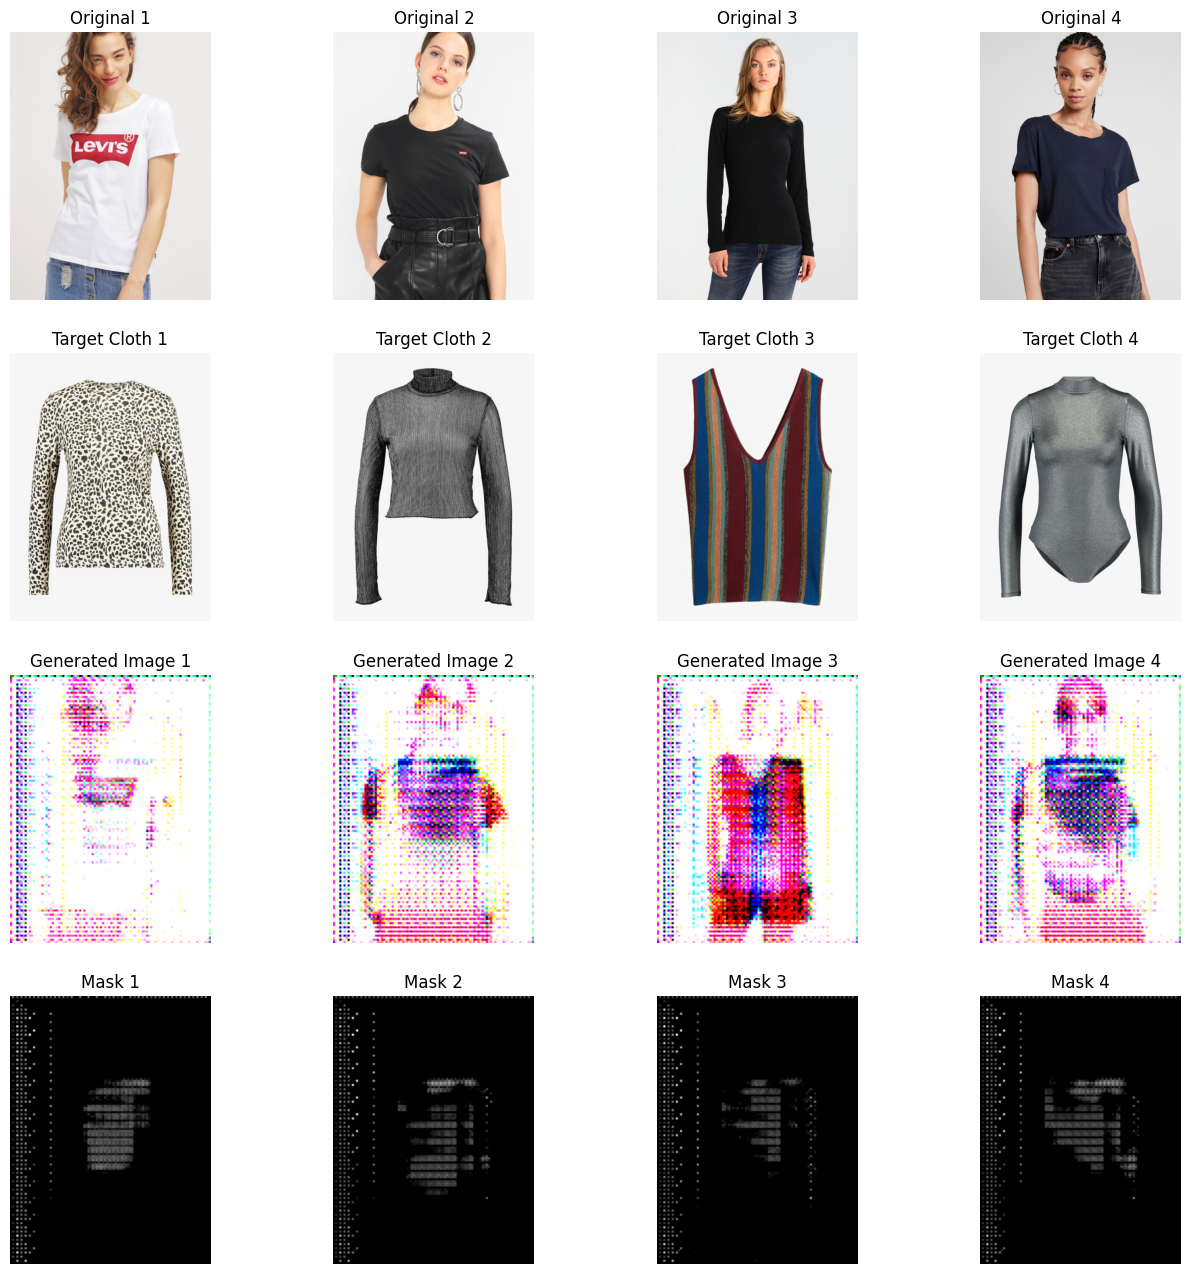

In [49]:
import matplotlib.pyplot as plt

def plot_images(images_raw, target_cloth, generated_images, masks):
    num_images = len(images_raw)

    fig, axes = plt.subplots(4, num_images, figsize=(4 * num_images, 16))

    for i in range(num_images):
        # Plot original images in the first row
        axes[0, i].imshow(images_raw[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i + 1}')

        # Plot target clothes in the second row
        axes[1, i].imshow(target_cloth[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Target Cloth {i + 1}')


        # Plot generated images in the third row
        #g = Variable(generated_images[i].squeeze(0))
        g = generated_images[i]
        g = Variable(g.squeeze(0))
        g = g.detach().cpu().numpy()
        #g = g.view(g.size()[1:])
        
        print(g.shape)
        g = np.transpose(g, (1,2,0))
        axes[2, i].imshow(g)
        axes[2, i].axis('off')
        axes[2, i].set_title(f'Generated Image {i + 1}')

        # Plot masks in the fourth row
        m = masks[i]
        m = Variable(m.squeeze(0))
        m = m.detach().cpu().numpy()
        m = np.transpose(m, (1,2,0))
        axes[3, i].imshow(m[:, :, 0], cmap='gray')  # Assuming the masks are 4-channel with the first channel as the binary mask
        axes[3, i].axis('off')
        axes[3, i].set_title(f'Mask {i + 1}')

    plt.show()

plot_images(x_i_raw,y_j_raw,images, masks)

## Training Results

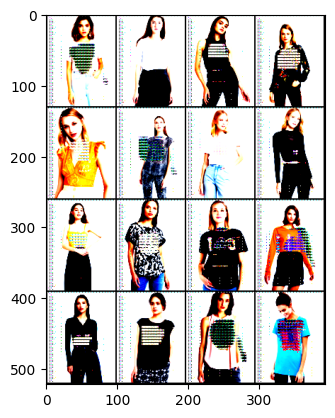

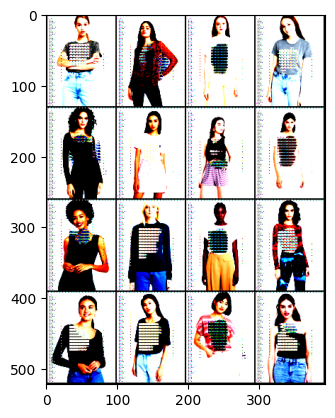

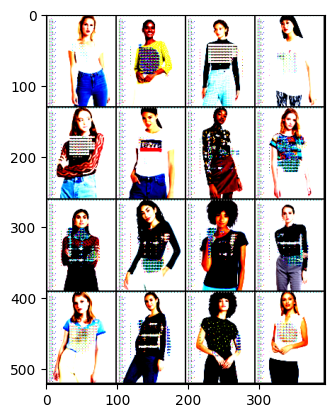

In [57]:
img = [load_img(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Code/WearVision/Fitting Model/images/images_{i}.png') for i in range(15,18)]
for i in range(3):
    plt.figure()
    plt.imshow(img[i])

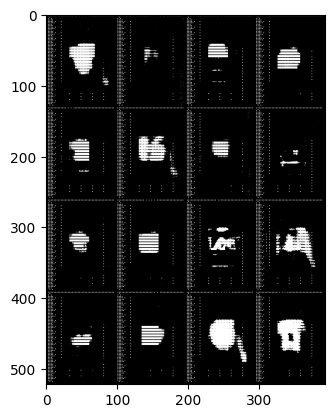

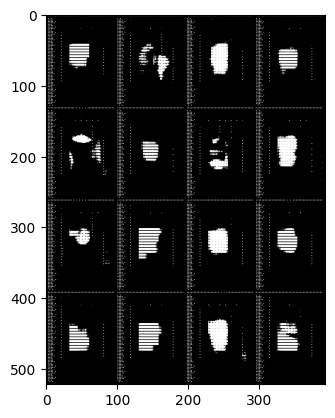

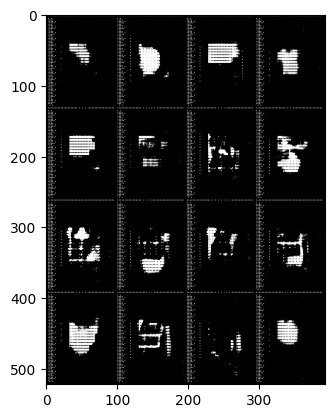

In [58]:
img = [load_img(f'/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/WearVision/Code/WearVision/Fitting Model/masks/masks_{i}.png') for i in range(15,18)]
for i in range(3):
    plt.figure()
    plt.imshow(img[i])